In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dftools

In [10]:
plt.style.use("cms")
plt.rcParams.update({
    "font.size": 10,
    #"figure.figsize": (3, 2.25),
    "figure.figsize": (2.7, 2.025),
    "figure.dpi": 100,
    "savefig.bbox": 'tight',
})

In [11]:
df = pd.read_csv("data/electron_sf_idiso.csv")
df.head(10)

,label,vars,var0_min,var0_max,var1_min,var1_max,value,stat_up,stat_down,syst_up,syst_down
0,CutBasedVetoWP,pt_eta,10.0,20.0,-2.500,-2.000,1.008208,0.036929,0.036929,0.0,0.0
1,CutBasedVetoWP,pt_eta,10.0,20.0,-2.000,-1.566,1.041830,0.043213,0.043213,0.0,0.0
2,CutBasedVetoWP,pt_eta,10.0,20.0,-1.444,-0.800,1.038560,0.034122,0.034122,0.0,0.0
3,CutBasedVetoWP,pt_eta,10.0,20.0,-0.800,0.000,1.022973,0.032080,0.032080,0.0,0.0
4,CutBasedVetoWP,pt_eta,10.0,20.0,0.000,0.800,0.996016,0.031588,0.031588,0.0,0.0
5,CutBasedVetoWP,pt_eta,10.0,20.0,0.800,1.444,1.015385,0.034035,0.034035,0.0,0.0
6,CutBasedVetoWP,pt_eta,10.0,20.0,1.566,2.000,1.023653,0.043394,0.043394,0.0,0.0
7,CutBasedVetoWP,pt_eta,10.0,20.0,2.000,2.500,1.018868,0.036382,0.036382,0.0,0.0
8,CutBasedVetoWP,pt_eta,20.0,35.0,-2.500,-2.000,1.010613,0.011249,0.011249,0.0,0.0
9,CutBasedVetoWP,pt_eta,20.0,35.0,-2.000,-1.566,1.011429,0.028468,0.028468,0.0,0.0


In [12]:
def draw1d(df, ax, labels, kwargs):
    xbins = np.array(sorted(set(list(df["eta_low"])+list(df["eta_high"]))))
    xcent = (df["eta_low"]+df["eta_high"])/2.

    ax.errorbar(
        xcent, df["correction"], 
        yerr = (df["unc_up"], df["unc_down"]),
        fmt='o', color='black',
    )

    ax.set_xlim(xbins.min(), xbins.max())
    ax.set_xlabel(labels["x"])
    ax.set_ylabel(labels["y"])
    
    #from matplotlib.ticker import ScalarFormatter
    #ax.yaxis.set_major_formatter(ScalarFormatter())
    #ax.set_xticks(xbins)
    #ax.set_yticks(ybins)
    
    dftools.draw.cms_label(ax, "") #"Preliminary")

In [31]:
def draw2d(df, ax, labels, kwargs):
    xidx = 0
    yidx = 1
    xbins = np.array(sorted(set(list(df["var{}_min".format(xidx)])+list(df["var{}_max".format(xidx)]))))
    ybins = np.array(sorted(set(list(df["var{}_min".format(yidx)])+list(df["var{}_max".format(yidx)]))))

    hist, _, _, im = ax.hist2d(
        df["var{}_min".format(xidx)]+1e-6, df["var{}_min".format(yidx)]+1e-6,
        bins = (xbins, ybins),
        weights = df["value"],
        cmap = "RdYlBu",
    )
    
    if "xscale" in kwargs:
        ax.set_xscale(kwargs["xscale"])
    if "yscale" in kwargs:
        ax.set_yscale(kwargs["yscale"])

    ax.set_xlim(kwargs.get("xlim", (xbins.min(), xbins.max())))
    ax.set_ylim(kwargs.get("ylim", (ybins.min(), ybins.max())))
    ax.set_xlabel(labels["x"])
    ax.set_ylabel(labels["y"])
    
    from matplotlib.ticker import ScalarFormatter
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(kwargs.get("xbins", xbins))
    ax.set_yticks(kwargs.get("ybins", ybins))
    
    for i in range(len(xbins)-1):
        for j in range(len(ybins)-1):
            if "condition" not in kwargs or kwargs["condition"](i, j, xbins, ybins):
                xpos = (xbins[i] + xbins[i+1])/2.
                if kwargs.get("xscale", "lin") == "log":
                    xpos = np.sqrt(xbins[i+1]*xbins[i])
                    
                ypos = (ybins[j] + ybins[j+1])/2.
                if kwargs.get("yscale", "lin") == "log":
                    ypos = np.sqrt(ybins[j+1]*ybins[j])
                    
                ax.text(
                    xpos, ypos, "{:.2f}".format(hist[i,j]),
                    ha='center', va='center', color='white',
                )
            
    im.set_clim(kwargs["clim"])
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(labels["z"])
    
    dftools.draw.cms_label(ax, "") #"Preliminary")
    return ax

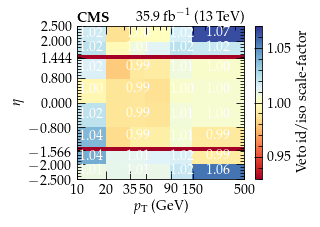

In [14]:
df = pd.read_csv("data/electron_sf_idiso.csv").set_index(["label", "vars"]).loc[("CutBasedVetoWP", "pt_eta"),:]
fig, ax = plt.subplots()
draw2d(
    df, ax,
    {"y": r'$\eta$', "x": r'$p_{\mathrm{T}}$ (GeV)', "z": r'Veto id/iso scale-factor'},
    {"clim": (0.93, 1.07), "xscale": 'log',
     "condition": lambda i, j, xbins, ybins: (i in [0, 2, 4, 5]) and (j in [0, 1, 3, 5, 6, 8, 10, 11]),
     "xbins": [10, 20, 35, 50, 90, 150, 500],
     "ybins": [-2.5, -2, -1.566, -0.8, 0, 0.8, 1.444, 2, 2.5]},
)
ax.tick_params(axis='x', which='minor', bottom=False)
fig.savefig("plots/electron_idiso_veto_sf.pdf")

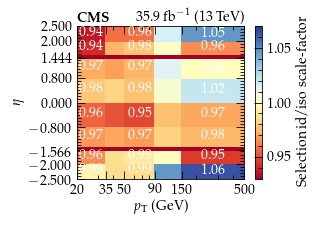

In [15]:
df = pd.read_csv("data/electron_sf_idiso.csv").set_index(["label", "vars"]).loc[("CutBasedTightWP", "pt_eta"),:]
fig, ax = plt.subplots()
draw2d(
    df, ax,
    {"y": r'$\eta$', "x": r'$p_{\mathrm{T}}$ (GeV)', "z": r'Selection id/iso scale-factor'},
    {"clim": (0.93, 1.07), "xscale": 'log',
     "condition": lambda i, j, xbins, ybins: (i in [0, 2, 4]) and (j in [0, 1, 3, 5, 6, 8, 10, 11]),
     "xbins": [20, 35, 50, 90, 150, 500],
     "ybins": [-2.5, -2, -1.566, -0.8, 0, 0.8, 1.444, 2, 2.5]},
)
fig.savefig("plots/electron_idiso_tight_sf.pdf")

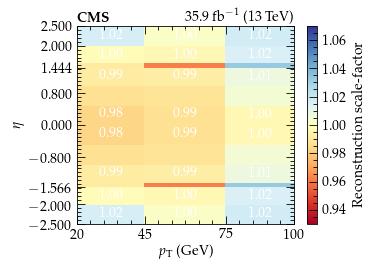

In [50]:
df = pd.read_csv("data/electron_sf_reco.csv").set_index(["label", "vars"]).loc[("Reco", "pt_eta"),:]
fig, ax = plt.subplots(figsize=(3.5, 2.625))
ax = draw2d(
    df, ax,
    {"y": r'$\eta$', "x": r'$p_{\mathrm{T}}$ (GeV)', "z": r'Reconstruction scale-factor'},
    {"clim": (0.93, 1.07), #"xscale": 'log',
     "condition": lambda i, j, xbins, ybins: (j in [0, 1, 3, 5, 6, 8, 10, 11]),
     "xbins": [20, 45, 75, 100],
     "ybins": [-2.5, -2, -1.566, -0.8, 0, 0.8, 1.444, 2, 2.5]},
)
fig.savefig("plots/electron_reco_sf.pdf")

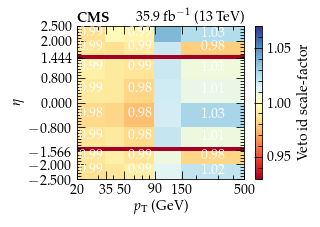

In [47]:
df = pd.read_csv("data/photon_sf_id.csv").set_index(["label", "vars"]).loc[("CutBasedLooseWP", "pt_eta"),:]
fig, ax = plt.subplots()
ax = draw2d(
    df, ax,
    {"x": r'$p_{\mathrm{T}}$ (GeV)', "y": r'$\eta$', "z": r'Veto id scale-factor'},
    {"clim": (0.93, 1.07), "xscale": 'log',
     "condition": lambda i, j, xbins, ybins: (i in [0, 2, 4]) and (j in [0, 1, 3, 5, 6, 8, 10, 11]),
     "xbins": [20, 35, 50, 90, 150, 500],
     "ybins": [-2.5, -2, -1.566, -0.8, 0, 0.8, 1.444, 2, 2.5]},
)
fig.savefig("plots/photon_id_veto_sf.pdf")

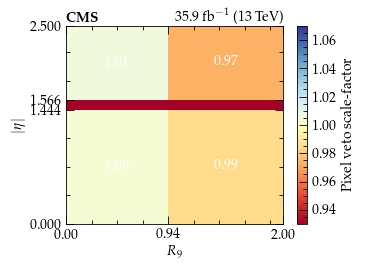

In [51]:
df = pd.read_csv("data/photon_sf_pixelveto.csv").set_index(["label", "vars"]).loc[("PixelVeto", "r9_abseta_pt"),:]
df.loc[(df["var0_max"]==10.),"var0_max"] = 2.
fig, ax = plt.subplots(figsize=(3.5, 2.625))
ax = draw2d(
    df, ax,
    {"x": r'$R_9$', "y": r'$|\eta|$', "z": r'Pixel veto scale-factor'},
    {"clim": (0.93, 1.07), #"xscale": 'log',
     "condition": lambda i, j, xbins, ybins: j in [0,2],
     "xbins": [0.00, 0.94, 2.00],
     "ybins": [0.00, 1.444, 1.566, 2.500],
    },
)
fig.savefig("plots/photon_pixelveto_sf.pdf")